# CHEMBL FILTERED CLUSTERING

## 1. Incremetal Global BitBirch Clustering

In [ ]:
import bblean

from rdkit import Chem


THRESHOLD = 0.6       
BRANCHING = 256            # adjust to memory
NBITS = 2048              # ECFP4

In [79]:
smiles_list = []

supplier = Chem.SDMolSupplier("chembl_filtered_2.sdf", sanitize=True, removeHs=True)
for mol in supplier:
    if mol is None:
        continue
    smiles_list.append(Chem.MolToSmiles(mol))



[15:43:18] Explicit valence for atom # 10 Si, 6, is greater than permitted
[15:43:18] ERROR: Could not sanitize molecule ending on line 60766518
[15:43:18] ERROR: Explicit valence for atom # 10 Si, 6, is greater than permitted
[15:43:40] Explicit valence for atom # 7 P, 7, is greater than permitted
[15:43:40] ERROR: Could not sanitize molecule ending on line 67713996
[15:43:40] ERROR: Explicit valence for atom # 7 P, 7, is greater than permitted
[15:44:48] Explicit valence for atom # 3 Ar, 1, is greater than permitted
[15:44:48] ERROR: Could not sanitize molecule ending on line 89932534
[15:44:48] ERROR: Explicit valence for atom # 3 Ar, 1, is greater than permitted


In [115]:
fps = bblean.fps_from_smiles(
    smiles_list,
    kind="ecfp4",
    pack=True,       
    n_features=2048
)


In [116]:
bb = bblean.BitBirch(
    threshold=THRESHOLD,
    branching_factor=BRANCHING,
    merge_criterion="diameter"
)


In [117]:
bb.fit(fps)


BitBirch(threshold=0.6, branching_factor=128, merge_criterion='diameter')

In [118]:
clusters = bb.get_cluster_mol_ids()


In [119]:
import numpy as np

# 3. Convert to label vector
labels = np.zeros(len(fps), dtype=np.int32)
for cid, members in enumerate(clusters):
    for idx in members:
        labels[idx] = cid

labels  # now each molecule has a cluster ID


array([1695079, 1502291, 1695161, ...,  802216,  728570, 1196020],
      shape=(2330024,), dtype=int32)

In [120]:
print(len(labels))
print(len(smiles_list))

2330024
2330024


In [121]:
import pandas as pd

df = pd.DataFrame({
    "SMILES": smiles_list,
    "cluster": labels
})

df.to_csv("chembl_bitbirch_clusters_3.csv", index=False)



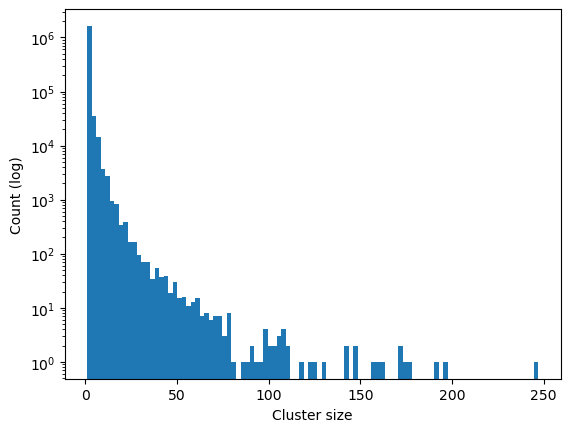

In [122]:
import matplotlib.pyplot as plt
plt.hist([len(c) for c in clusters], bins=100)
plt.yscale("log")
plt.xlabel("Cluster size")
plt.ylabel("Count (log)")
plt.show()


In [123]:
import numpy as np

representatives = {}
for idx, c in enumerate(labels):
    if c not in representatives:
        representatives[c] = idx

rep_indices = np.array(list(representatives.values()))
rep_smiles = [smiles_list[i] for i in rep_indices]

df_rep = pd.DataFrame({"SMILES": rep_smiles})
df_rep.to_csv("chembl_bitbirch_representatives_3.csv", index=False)



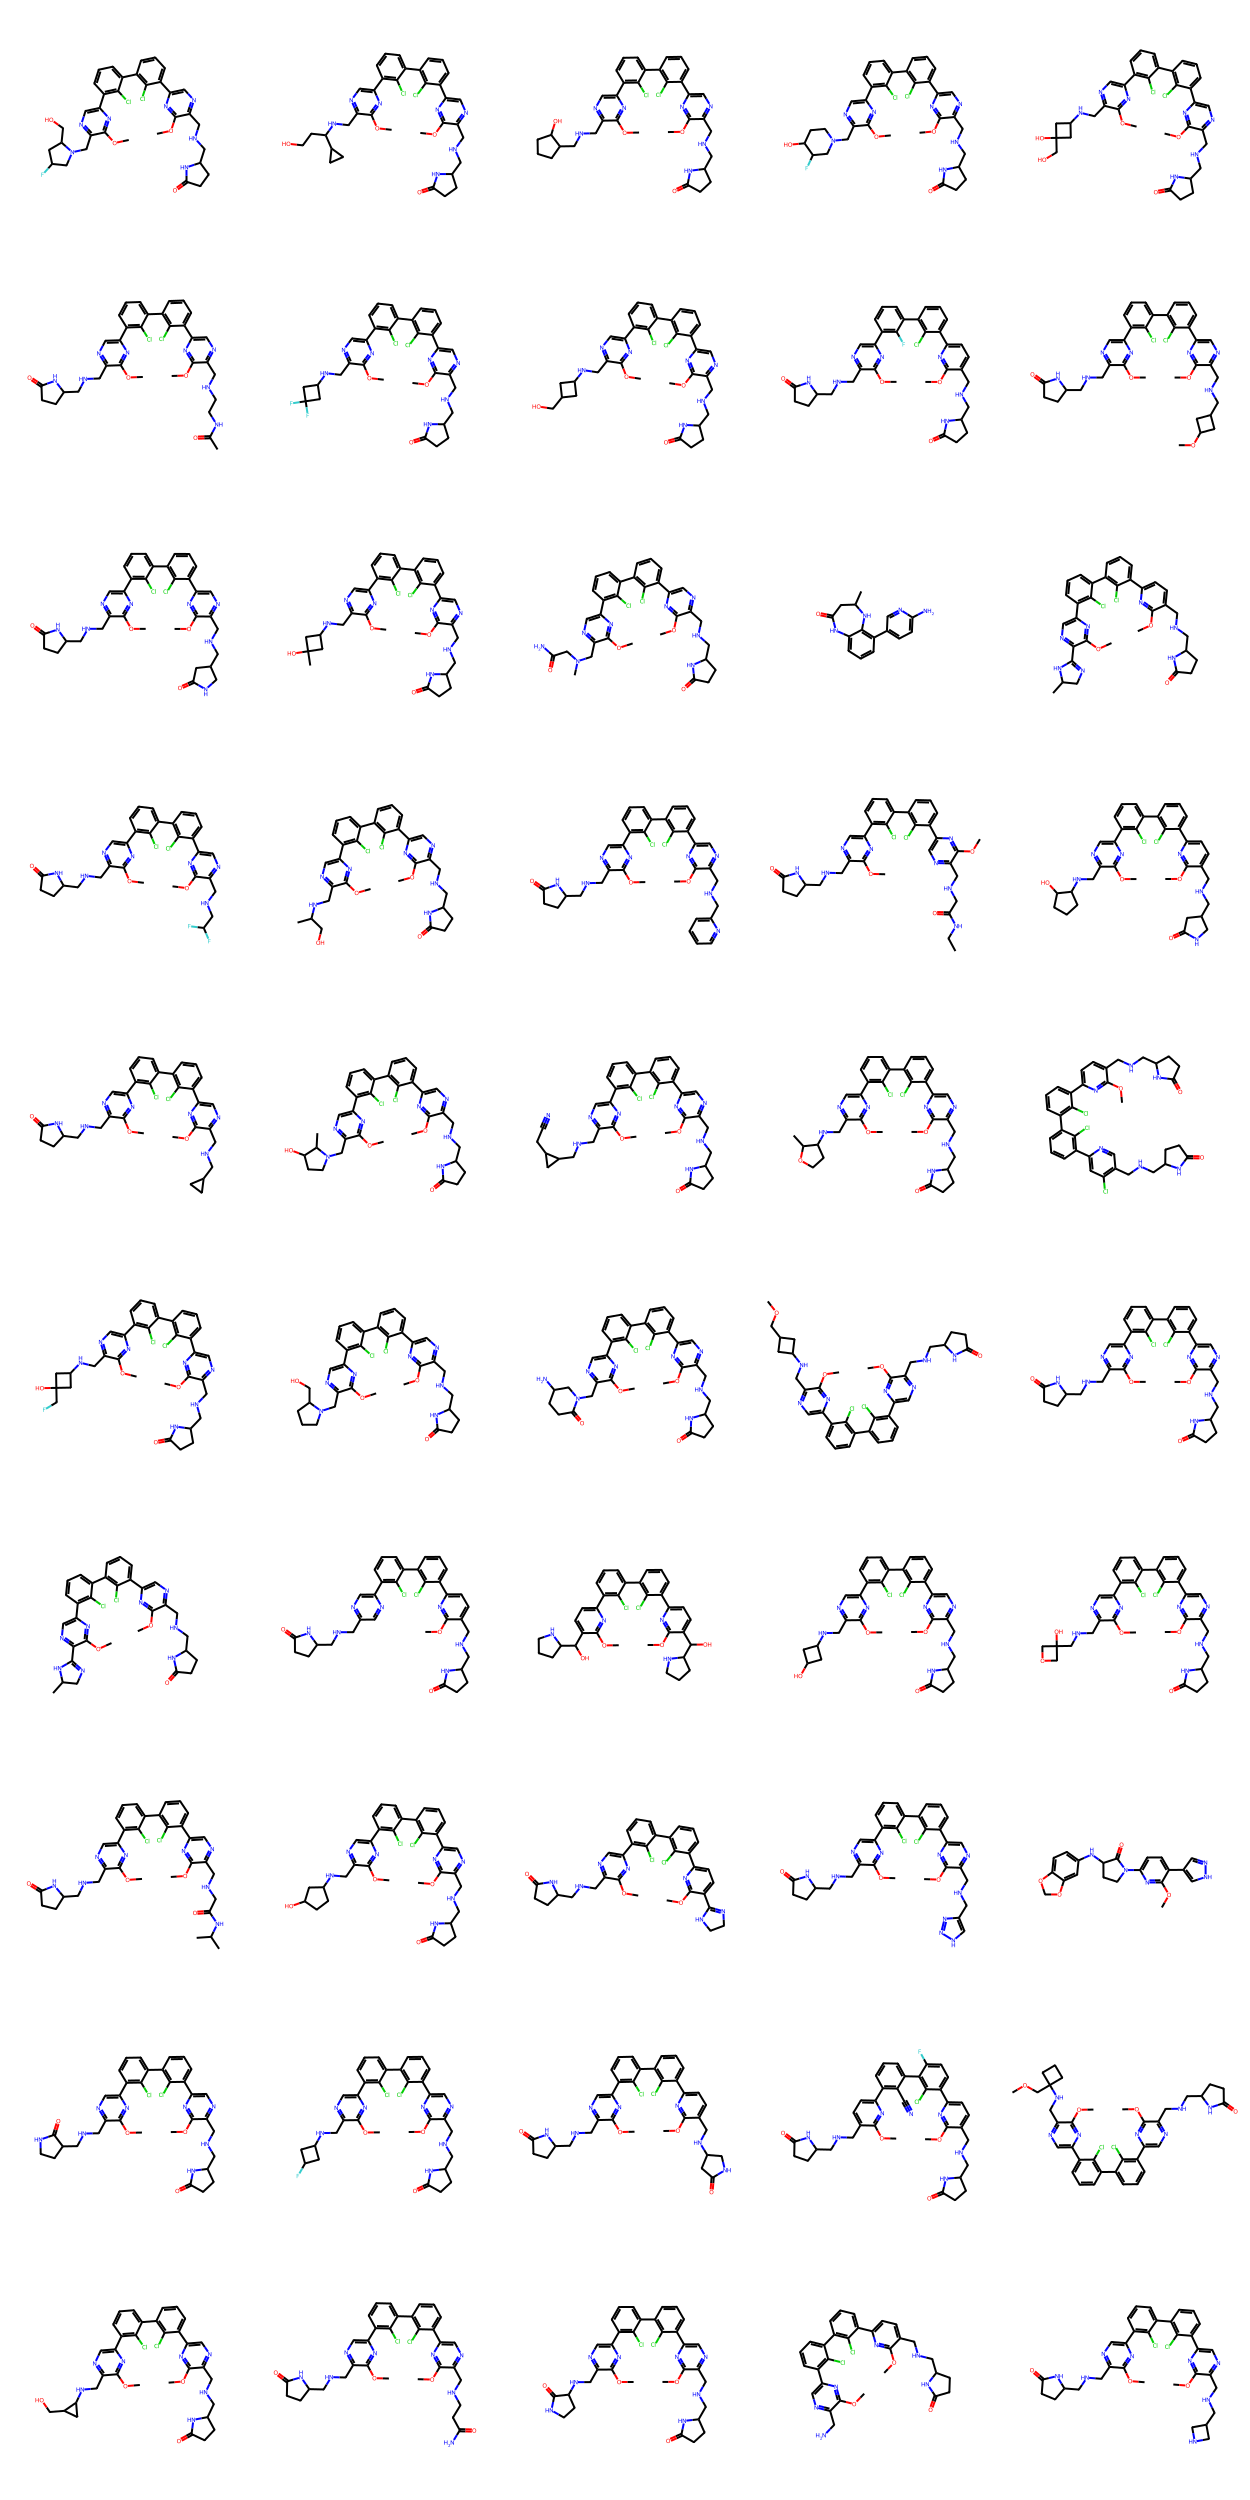

In [124]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage

CID = 123    # cluster ID you want to inspect
sample = df[df.cluster == CID].SMILES.iloc[:50].tolist()

mols = [Chem.MolFromSmiles(s) for s in sample]
img = MolsToGridImage(mols, molsPerRow=5, subImgSize=(250,250))
img
